In [63]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import skimage

In [64]:
from skimage import util #for converting data type into float

In [65]:
#get the data stored in combine_CT notebook
%store -r dicom_array

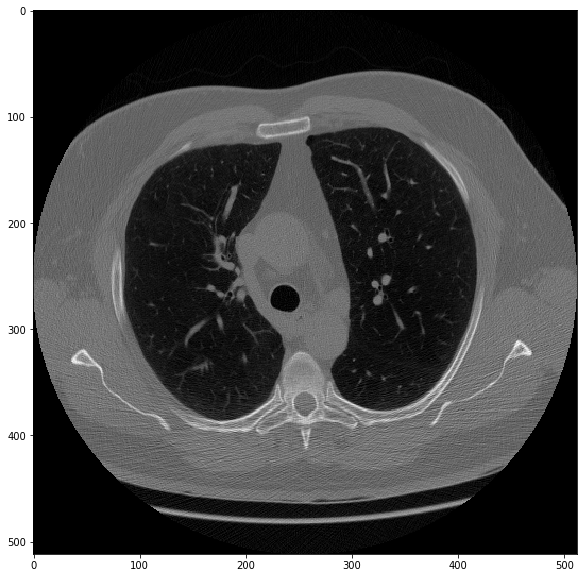

In [66]:
plt.figure(figsize=(20,10));
plt.imshow(dicom_array, cmap='gray')

In [67]:
dicom_array.dtype

dtype('uint16')

In [68]:
#getting data between 0-255 and converting the data type
dicom_array = dicom_array / dicom_array.max()
dicom_array = 255 * dicom_array
img = dicom_array.astype('uint8')

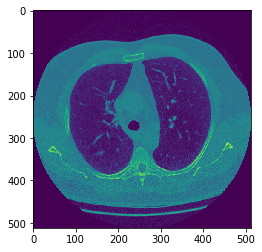

In [69]:
plt.imshow(img)

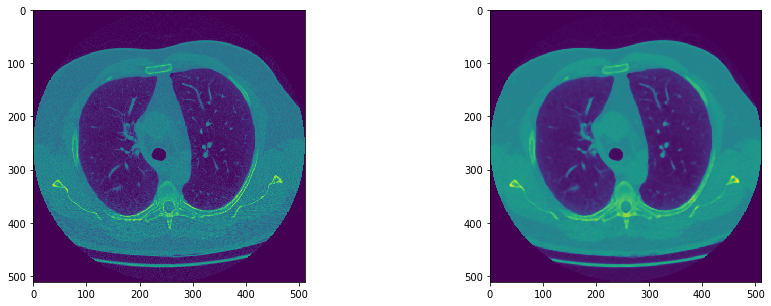

In [70]:
from skimage import filters

img_denoised = filters.median(img, selem=np.ones((5,5)))
f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(img)
ax1.imshow(img_denoised)

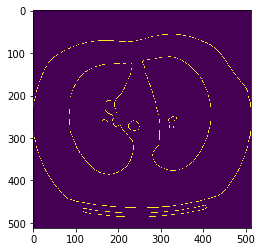

In [71]:
#detect edges
from skimage import feature

img_denoised =  util.img_as_float(img_denoised)
edges = skimage.feature.canny(img_denoised, sigma=3.95) 
plt.imshow(edges)

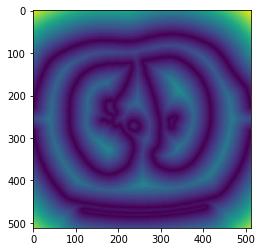

In [72]:
from scipy.ndimage import distance_transform_edt

dt = distance_transform_edt(~edges)
plt.imshow(dt)

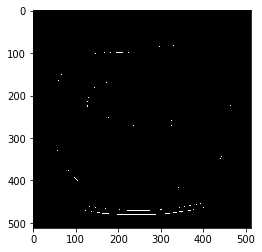

In [73]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=5)
plt.imshow(local_max, cmap='gray')

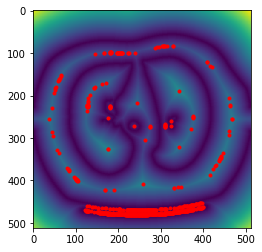

In [74]:
peak_idx = feature.peak_local_max(dt, indices=True, min_distance=5)
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')
plt.imshow(dt)

In [75]:
from skimage import measure

markers = measure.label(local_max)

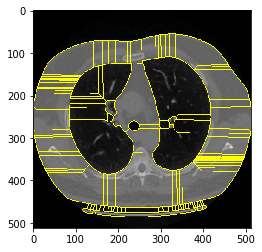

In [76]:
from skimage import morphology, segmentation


labels = morphology.watershed(-dt, markers)
plt.imshow(segmentation.mark_boundaries(img_denoised, labels))

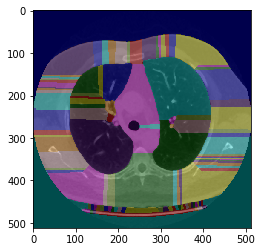

In [77]:
from skimage import color
plt.imshow(color.label2rgb(labels, image=img_denoised));

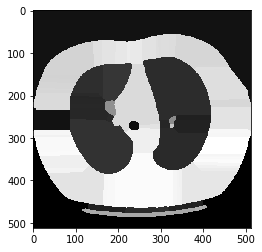

In [78]:
plt.imshow(color.label2rgb(labels, image=img_denoised, kind='avg'), cmap='gray')

In [79]:
regions = measure.regionprops(labels, intensity_image=img_denoised)

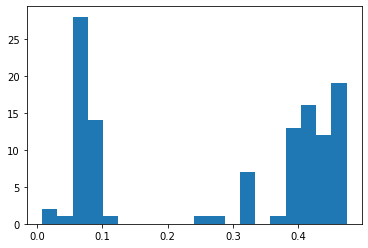

In [80]:
region_means = [r.mean_intensity for r in regions]
#plot histogram
plt.hist(region_means, bins=20);

In [81]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
region_means = np.array(region_means).reshape(-1,1)

In [82]:
model.fit(region_means) # fit the model to means
print(model.cluster_centers_)

[[0.41459971]
 [0.07266252]]


In [83]:
bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0])

In [84]:
classified_labels = labels.copy() #we copy the original labels given by 'watershed' function

#we  take the combination of predicted labels with different labels
for bg_fg, region in zip(bg_fg_labels, regions):
    #relabel the image according to the coordinates of each region, we assign whether its background and foreground
    classified_labels[tuple(region.coords.T)] = bg_fg 

In [85]:
classified_labels.shape

(512, 512)

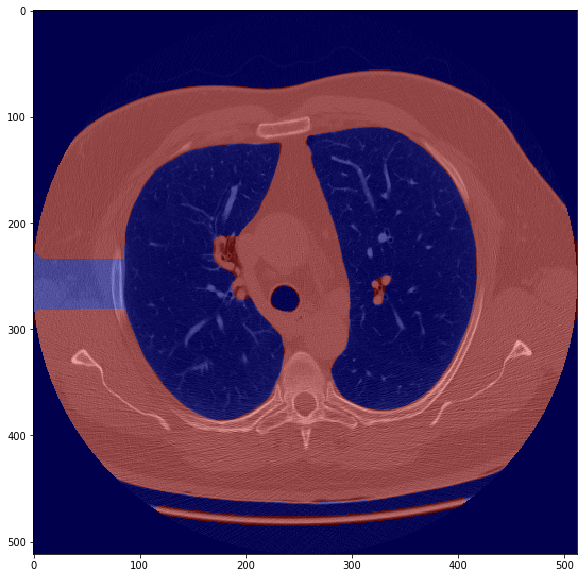

In [86]:
plt.figure(figsize=(20,10));
plt.imshow(color.label2rgb(classified_labels, image=img));

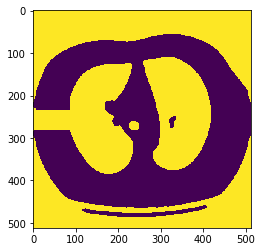

In [87]:
plt.imshow(classified_labels)

In [88]:
# yellows are 0s and bluish is 1

mask_indx = np.where(classified_labels < 1)
test = img.copy()
test[mask_indx] = 0

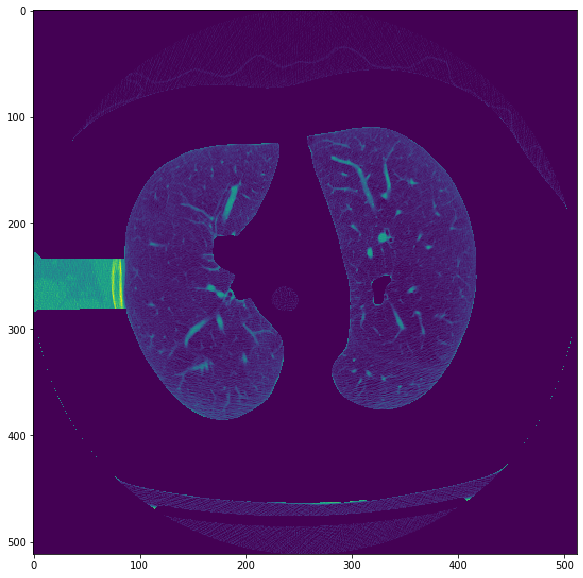

In [89]:
plt.figure(figsize=(20,10));
plt.imshow(test)